<div style="text-align:center; color:#FFFFFF; font-family:newtimeroman; font-size:350%; background-color:#A0A0A0; border-radius: 90px 90px;">
    Car Brand prediction
</div>

<span style="font-size:20px; font-family:newtimeroman;">The objective of this analysis is to build a CNN model able to accurately identify the brand of a car in an image.</span>

Contents:

0. Setting the environment
1. EDA
2. Train/Test split
3. Training
4. Testing

<div style="text-align:center; background-color:#A0A0A0; color:#FFFFFF; font-family:serif; font-size:25px; border-radius: 5px 5px;">
    0. Setting the environment
</div>

In [4]:
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
#from fastai.vision.all import *

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [6]:
# PARAMETERS
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

<div style="text-align:center; background-color:#A0A0A0; color:#FFFFFF; font-family:serif; font-size:25px; border-radius: 5px 5px;">
    1. EDA
</div>

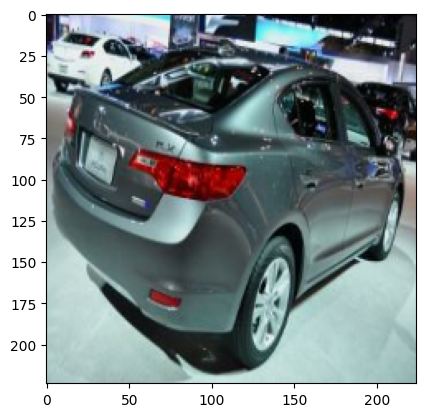

In [9]:
# Reading images
def read_and_decode(filename, reshape_dims):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, reshape_dims)

# Showing images
def show_image(filename):
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    plt.imshow(img.numpy())

show_image('/kaggle/input/the-car-connection-picture-dataset/Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_Bbw.jpg')

In [10]:
# Extract paths
images = tf.io.gfile.glob('/kaggle/input/the-car-connection-picture-dataset/*.jpg')
print("--> Number of images: ", len(images))

64467

In [35]:
# Extract brand name from paths
img_paths = pd.DataFrame(images, columns = ['path'])
brands = img_paths['path'].apply(lambda x: x.split('/')[-1].split('_')[0])

# Check the brands
print("--> Total number of brands: ",brands.nunique())
brand_count = brands.value_counts().reset_index().rename({"path": "brand"}, axis=1)
brand_count.head()

--> Total number of brands:  42


,brand,count
0,Chevrolet,5079
1,Toyota,4598
2,Ford,4416
3,BMW,4121
4,Nissan,3881


<span style="font-size:20px; font-family:newtimeroman;">Our dataset contains 64467 images and 42 different brands.</span>

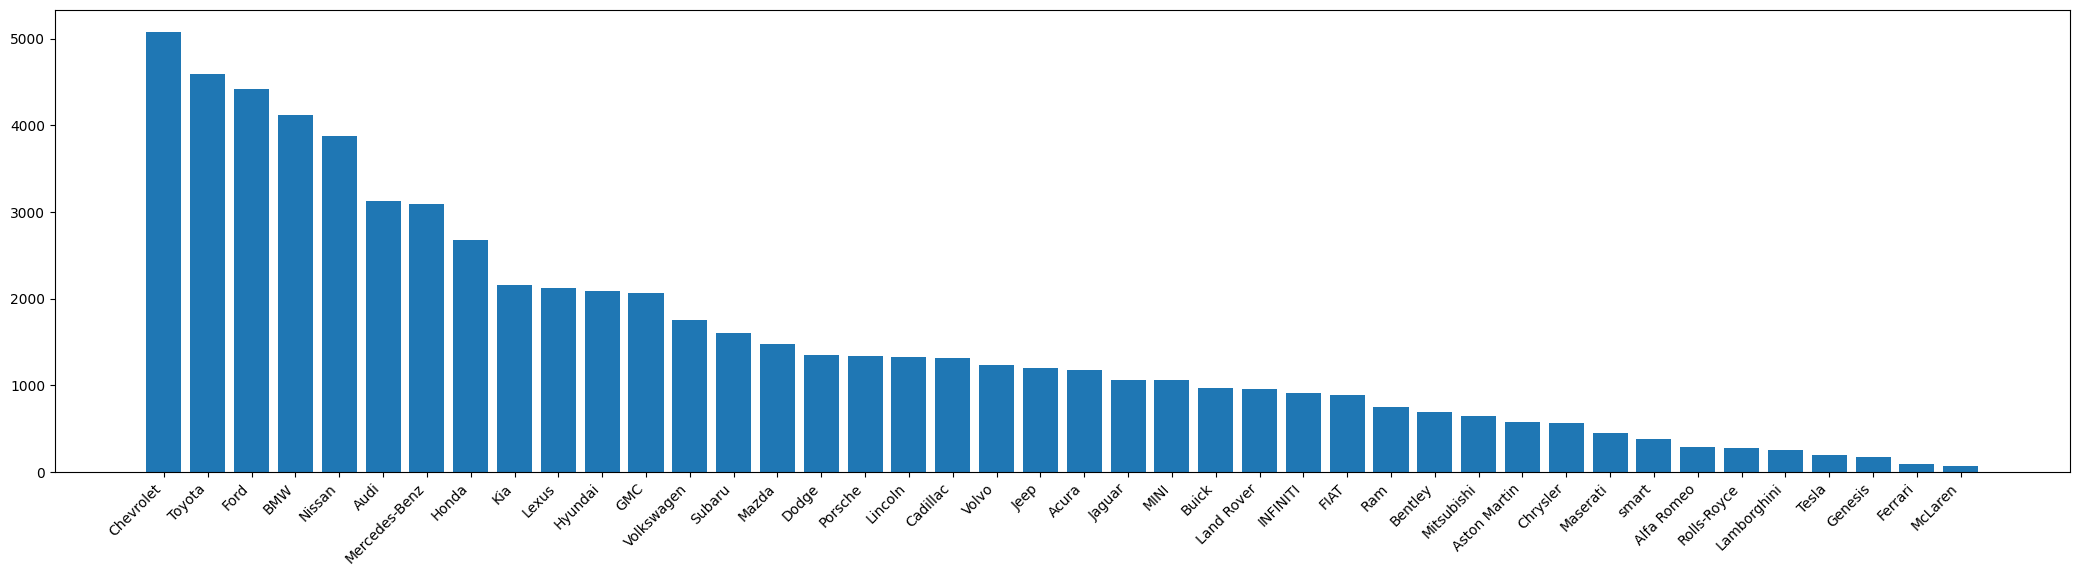

In [32]:
fig, ax = plt.subplots(figsize=(26,6))

ax.bar(brand_count['brand'], brand_count['count'])
ax.set_xticks(range(len(brand_count['brand'])))
ax.set_xticklabels(brand_count['brand'], rotation=45, ha='right')

plt.show()

<div style="text-align:center; background-color:#A0A0A0; color:#FFFFFF; font-family:serif; font-size:25px; border-radius: 5px 5px;">
    2. Train/Test split
</div>

<span style="font-size:18px"> It is better to set aside the images that we'll use for evaluating the model so we're splitting the data into training and testing sets. </span>

In [ ]:
train_file_paths, test_file_paths, train_labels, test_labels = train_test_split(img_paths, brands, test_size=0.2, random_state=42)

os.mkdir('/kaggle/working/train')
os.mkdir('/kaggle/working/test')

<div style="text-align:center; background-color:#A0A0A0; color:#FFFFFF; font-family:serif; font-size:25px; border-radius: 5px 5px;">
    3. Training
</div>

In [ ]:
# create a linear model in Keras
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    tf.keras.layers.Dense(len(brands))
])

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
cars = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(128)
)

In [ ]:
path = '/kaggle/input/the-car-connection-picture-dataset'
dls = cars.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1, unique=True)

In [ ]:
cars = cars.new(item_tfms=RandomResizedCrop(128), 
                batch_tfms=aug_transforms(mult=2))
dls = cars.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

# Training

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

<div style="text-align:center; background-color:#A0A0A0; color:#FFFFFF; font-family:serif; font-size:25px; border-radius: 5px 5px;">
    4. Testing
</div>